
**Due to having 1000+ features alltogether when creating dummies features (due to the different state fips code that represents different location), rerunning this notebook will take over 30 minutes. thus it is not recommended to re-run the notebook.**

## Exercises

**This homework focuses on training and evaluating prediction models for a particular problem and dataset.**
The data comes from the Centers for Disease Control and Prevention (CDC: https://covid.cdc.gov/covid-data-tracker/). CDC is a USA health protection agency and is in charge of collecting data about the COVID-19 pandemic, and in particular, tracking cases, deaths, and trends of COVID-19 in the United States. CDC collects and makes public deidentified individual-case data on a daily basis, submitted using standardized case reporting forms. In this analysis, we focus on using the data collected by CDC to build a data analytics solution for death risk prediction. 

The dataset we work with is a sample of the public data released by CDC, where the outcome for the target feature **death_yn** is known (i.e., either 'yes' or 'no'):
https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf

The goal in this homework is to work with the data to build and evaluate prediction models that capture the relationship between the descriptive features and the target feature **death_yn**. 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import graphviz
from graphviz import Source

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Part 1: Data Understanding and Preparation

The original dataset form CDC is been cleaned in another Jupyter notebook file named "DataPreparation.ipynb". <br>The accompanying Data Quality Report is attached as "Data_Quality_Report_Initial_Findings.pdf". Below also shows a summary of the data quality plan:
<br>

### Summary of data quality plan:

| Feature                                |    Data   Quality Issue              | Data Quality Plan                                      |
|----------------------------------------|--------------------------------------|--------------------------------------------------------|
|     case_month                         |     -                                |     -                                                  |
|     case_onset_interval                |     large   amount null values       |     drop   feature                                     |
|     case_positive_specimen_interval    |     large   amount null values       |     drop   feature                                     |
|     state_fips_code                    |     -                                |     -                                                  |
|     res_state                          |     duplicate   feature              |     drop   feature                                     |
|     country_fips_code                  |     duplicate   feature                   |     drop feature                          |
|     res_county                         |     duplicate   feature              |     drop   feature                                     |
|     age_group                          |     null/missing/unknown   values    |     combine   “unknown”and null to “missing” column    |
|     sex                                |     null/missing/unknown   values    |     combine   “unknown”and null to“missing” column     |
|     race                               |     null/missing/unknown   values    |     combine   “unknown”and null to“missing” column     |
|     ethnicity                          |     null/missing/unknown   values    |     combine   “unknown”and null to“missing” column     |
|     process                            |     large   amount null values       |     drop   feature                                     |
|     exposure_yn                        |     large   amount null values       |     drop   feature                                     |
|     current_status                     |     -                                |     -                                                  |
|     symptom_status                     |     large   amount null values       |     drop   feature                                     |
|     hosp_yn                            |     null/missing/unknown   values    |     combine   “unknown”and null to“missing” column     |
|     icu_yn                             |     null/missing/unknown   values    |     combine   “unknown”and null to“missing” column     |
|     underlying_conditions_yn           |     null/missing/unknown   values    |     combine   “unknown”and null to“missing” column     |
|     death_yn                           |     -                                |     -                                                  |

##  1.1 Split the dataset into two datasets: 70% training and 30% test

In [2]:
#read the cleanes csv file
df = pd.read_csv("dataSource/CLEANED-UPDATED-covid19-cdc.csv")
df.head(5)

,case_month,county_fips_code,age_group,sex,race,ethnicity,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2020-12-01,4019.0,65+ years,Female,Multiple/Other,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Yes,Missing
1,2020-03-01,36081.0,18 to 49 years,Male,Asian,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Yes,Yes,Yes
2,2021-09-01,36047.0,65+ years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Missing,Missing,Yes,Missing
3,2021-01-01,51087.0,65+ years,Male,White,Non-Hispanic/Latino,Probable Case,Missing,Missing,Yes,Missing
4,2021-11-01,42019.0,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,No,Missing,Yes,Yes


Checking the shape, datatypes and missing values of the columns:

In [3]:
df.shape

(36421, 11)

In [4]:
df.dtypes

case_month                   object
county_fips_code            float64
age_group                    object
sex                          object
race                         object
ethnicity                    object
current_status               object
hosp_yn                      object
icu_yn                       object
death_yn                     object
underlying_conditions_yn     object
dtype: object

In [5]:
df.isna().sum()

case_month                     0
county_fips_code            2207
age_group                      0
sex                            0
race                           0
ethnicity                      0
current_status                 0
hosp_yn                        0
icu_yn                         0
death_yn                       0
underlying_conditions_yn       0
dtype: int64

#### Converting columns into suitable data types<br>

After examining the features:<br><br>
i. 'case_month' should be changed to datetime format<br><br>
ii. 'county_fips_code' have no numeric meaning (just a representation of location), thus turn them from 'int64' to 'category' type. <br><br>
iii. The targeted feature "death_yn" should be converted into numeric feature which is mapped 'Yes': 1, "No": 0 and stored as "int64"<br><br>
iv. 'hosp_yn', icu_yn', and 'underlying_conditions_yn' should be converted into dummy numeric feature which is mapped 'Yes': 1, "No": 0, 'Missing: 999 and stored. As there are missing values in the data, we replace it with a strange value 999 for the moment for dealing with NaN values. <br><br>
v. 'age_group', ‘ethicity','race' should be converted into dummy numeric features and mapped to uniqie data for the featuers.
vii. All other columns of type 'object' should be changed into 'category' for future modelling use into dummy features.

In [6]:
#i. changing 'case_month' to datetime datatype
df['case_month'] = pd.to_datetime(df['case_month'])

#ii. changing 'county_fips_code' to type 'object' (will be converted into category later)
df['county_fips_code'] = df['county_fips_code'].astype('object')

#iii. convert death_yn to 0,1, and int64 type for future modelling work
df['death_yn'] = df['death_yn'].map({'Yes': 1, "No": 0})
df['death_yn'] = df['death_yn'].astype('int64')

#iv. convert 'hosp_yn', icu_yn', and 'underlying_conditions_yn'
df['hosp_yn'] = df['hosp_yn'].map({'Yes': 1, "No": 0, "Missing": 999})
df['hosp_yn'] = df['hosp_yn'].astype('object')

df['icu_yn'] = df['icu_yn'].map({'Yes': 1, "No": 0, "Missing": 999})
df['icu_yn'] = df['icu_yn'].astype('object')

df['underlying_conditions_yn'] = df['underlying_conditions_yn'].map({'Yes': 1, "No": 0, "Missing": 999})
df['underlying_conditions_yn'] = df['underlying_conditions_yn'].astype('object')


In [7]:
#v. 'age_group' should be converted into dummy numeric features.
df['age_group'].unique()

array(['65+ years', '18 to 49 years', '50 to 64 years', 'Missing',
       '0 - 17 years'], dtype=object)

In [8]:
df['age_group'] = df['age_group'].map({'0 - 17 years': 1, "18 to 49 years": 2, "50 to 64 years" : 3, "65+ years": 4,  "Missing": 999})
df['age_group'] = df['age_group'].astype('object')

In [9]:
#v. 'race' should be converted into dummy numeric features.
df['race'].unique()

array(['Multiple/Other', 'Asian', 'White', 'Missing', 'Black',
       'American Indian/Alaska Native',
       'Native Hawaiian/Other Pacific Islander'], dtype=object)

In [10]:
df['race'] = df['race'].map({'Multiple/Other': 1, "Asian": 2, "White" : 3, "Black": 4, "American Indian/Alaska Native": 5, "Native Hawaiian/Other Pacific Islander": 6, "Missing": 999})
df['race'] = df['race'].astype('object')

In [11]:
#v. 'ethnicity' should be converted into dummy numeric features.
df['ethnicity'].unique()

array(['Non-Hispanic/Latino', 'Hispanic/Latino', 'Missing'], dtype=object)

In [12]:
df['ethnicity'] = df['ethnicity'].map({'Non-Hispanic/Latino': 1, "Hispanic/Latino": 2, "Missing": 999})
df['ethnicity'] = df['ethnicity'].astype('object')

In [13]:
#vi. Select the remaining columns of type 'object' and change their data type into 'category'
object_columns = df.select_dtypes(['object']).columns

for column in object_columns:
    df[column] = df[column].astype('category')

check updated datatypes:

#### Setup Column types
setup the categorical, datetime, continuous and target features

In [14]:
#categorical columns
categorical_columns = object_columns

#datetime_column
datetime_columns = df.select_dtypes(['datetime64']).columns

#numeric columns
continuous_columns = df.select_dtypes(['int64']).columns

In [15]:
df.dtypes

case_month                  datetime64[ns]
county_fips_code                  category
age_group                         category
sex                               category
race                              category
ethnicity                         category
current_status                    category
hosp_yn                           category
icu_yn                            category
death_yn                             int64
underlying_conditions_yn          category
dtype: object

There are no continuous features apart from the targeted feature.

##### Split the dataset into two datasets: 70% training and 30% test
- First we will set the target feature "y" to be death_yn
- Then we will set "X" to be the remaining features in the dataframe i.e. we drop "death_yn" from the dataframe

In [16]:
y = pd.DataFrame(df["death_yn"])
X = df.drop(["death_yn"],axis=1)
continuous_columns = continuous_columns.drop("death_yn")

- The train test split will randomly split the dataset with the given test size
- Setting random state=1 will allow the <b>random shuffle</b> to be repeated within this notebook only

In [17]:
# Split the dataset into two datasets randomly: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("Original Dataset Range: ",df.shape[0])
print("Training Set(70%):\t rows 0 to", round(X_train.shape[0]))
print("Test Set (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

Original Dataset Range:  36421
Training Set(70%):	 rows 0 to 25494
Test Set (30%): 	 rows 25494 to 36421


## 1.2 Exploring Plots on Training Set for Features Selection for the Models

We will only be using the training set for plotting the relationships. Apart from the target feature 'death_yn', there are no continuous feature in this analysis, thus we will skip the correlatiom between comtinuous features and jump into correlation between time series and categorical feature.

### 1.2.1 Datetime Series and the Target Feature
we will plot a stack barchart to see whether the relationship between datetime series and death

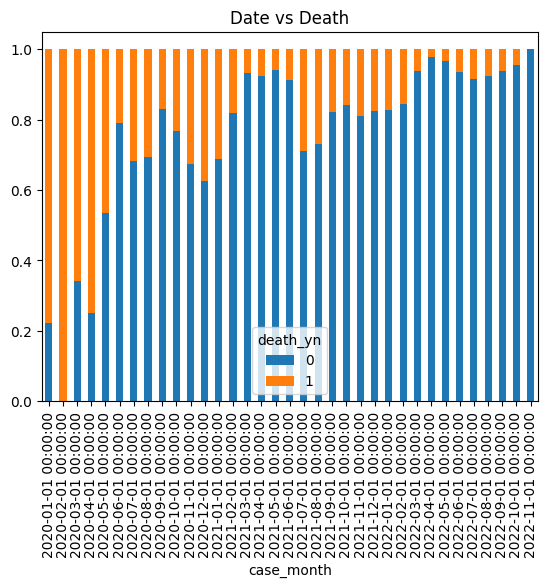

In [18]:
#seeing the ratio/percentage of each unique data category
percentagecrossx1 = pd.crosstab(df['case_month'], df['death_yn']).apply(lambda r: r/r.sum(), axis=1)
ax = percentagecrossx1.plot.bar(stacked=True, title = "Date vs Death")

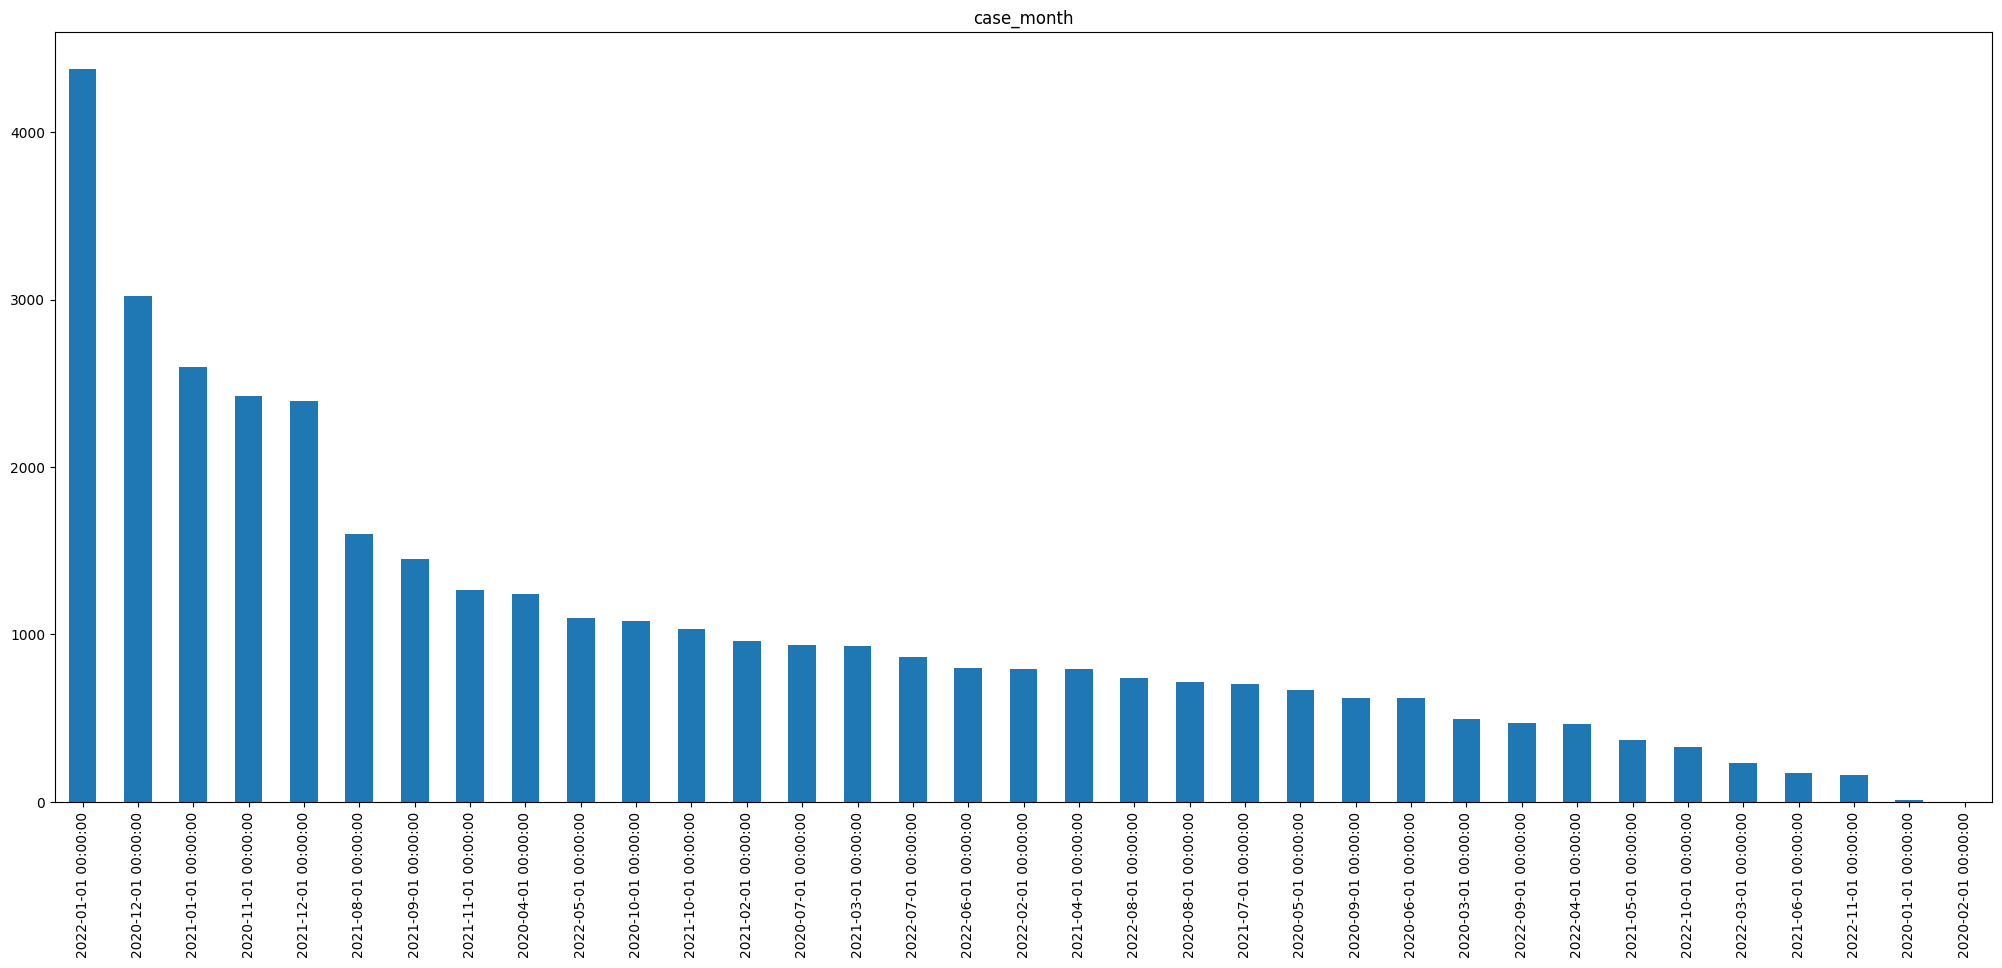

In [19]:
df["case_month"].value_counts().plot(kind='bar', figsize=(25,10))
plt.title("case_month")
plt.show()

#### Observation and Discussion:
From the stacked bar plot above, we can see a trend of when the year increases, the death percentage decreases. The case month from our selected features as there are only three years worth of data, and for each month there are no visible seasonal effect. The decrease in case recorded is due to the case recorded reduces over time, as shown in the case_month bar plot. Thus, we decide to drop this feature for the modelling.


In [20]:
to_be_dropped = ['case_month']

### 1.2.3 Categorical Features and the Target Feature
We will plot pairwise interaction between each categorical feature against the target 'death_yn'. We will find features that are better at predicting the target feature and choose a subset of continuous features we find promising (if any) and justify our choice.<br><br> The categorical features are: <br>state_fips_code, age_group, sex, race, ethnicity, current_status, hosp_yn, icu_yn and underlying_conditions_yn.<br><br>From a logical point of view, state_fips_code represents location of the case and they are too disperse and large amount of different unique states and country, and is a factor regarding to location rather than the patient's personal health problem, thus is not suitable to be fed into our model for predicting death for our project. We will remove this feature from consideration for features into the mode. 

In [21]:
categorical_columns = categorical_columns.drop(['county_fips_code'])
to_be_dropped.append('county_fips_code')

##### Create stacked bar plots for all categorical features

age_group
Bar Plot: 


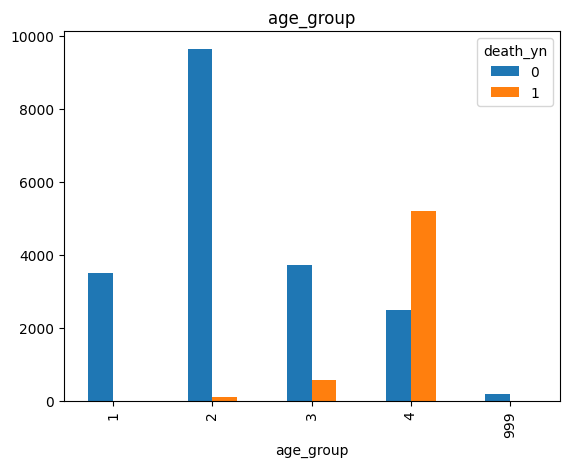

Stacked bar plot: 


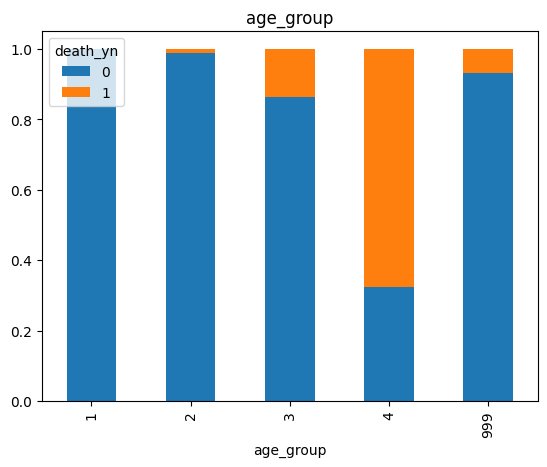

sex
Bar Plot: 


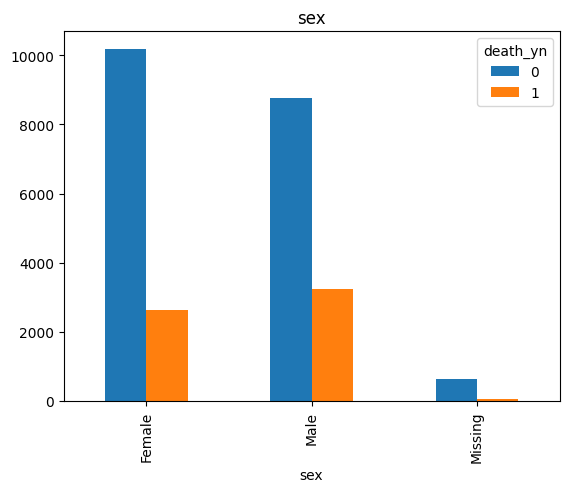

Stacked bar plot: 


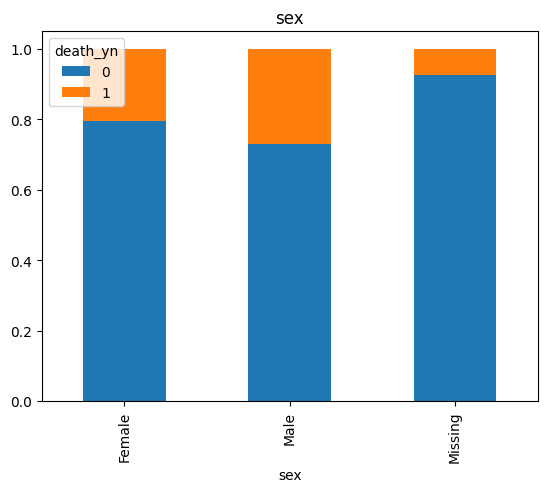

race
Bar Plot: 


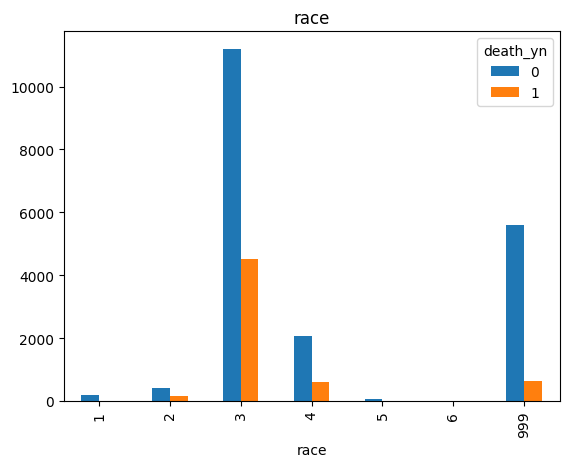

Stacked bar plot: 


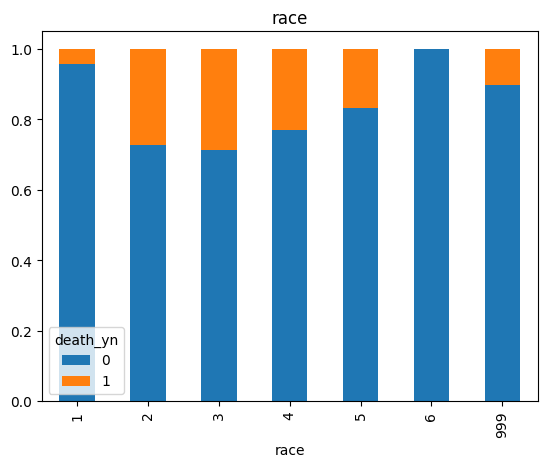

ethnicity
Bar Plot: 


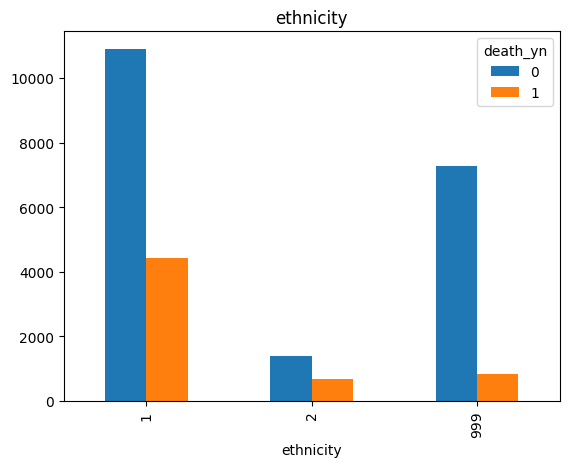

Stacked bar plot: 


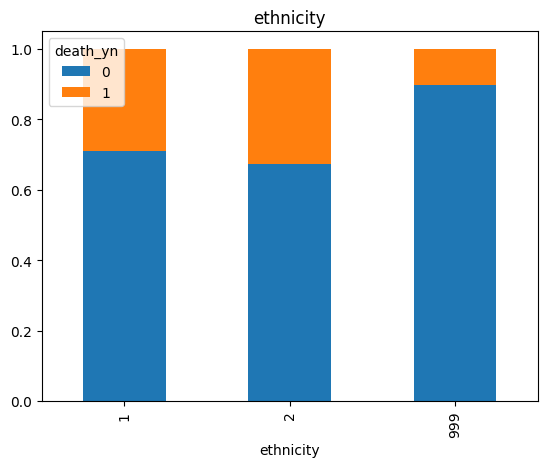

current_status
Bar Plot: 


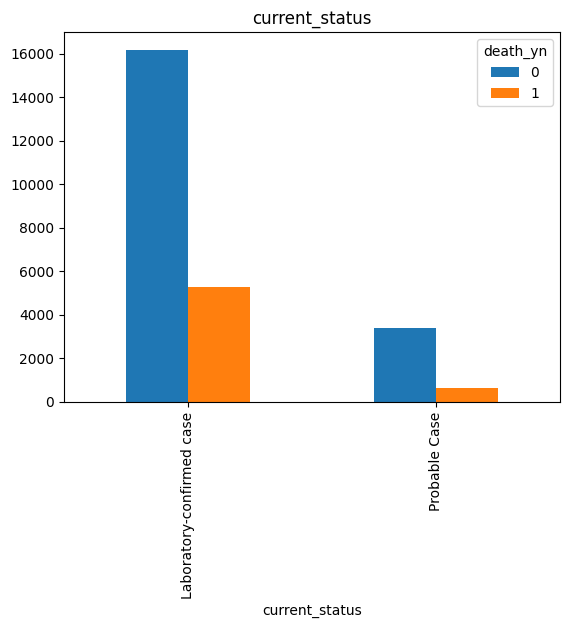

Stacked bar plot: 


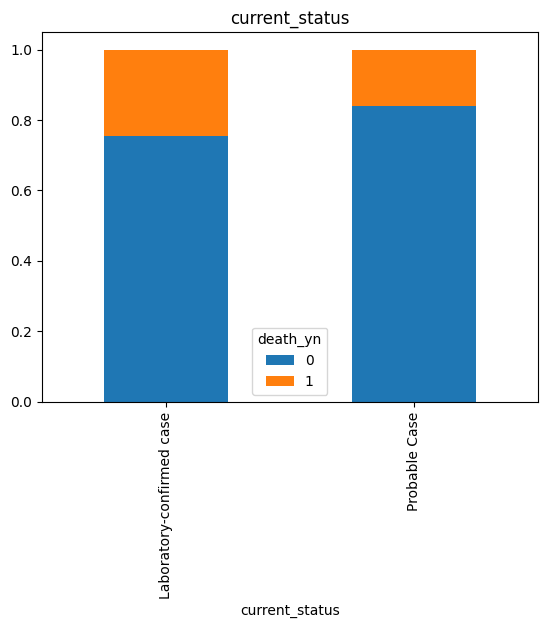

hosp_yn
Bar Plot: 


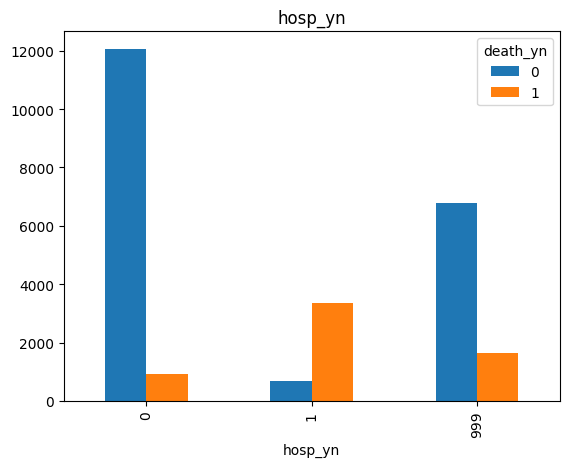

Stacked bar plot: 


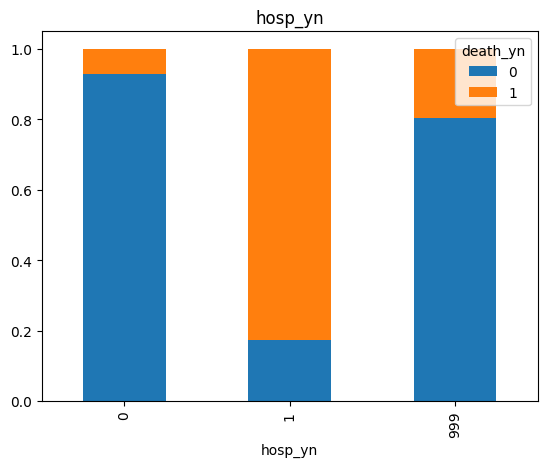

icu_yn
Bar Plot: 


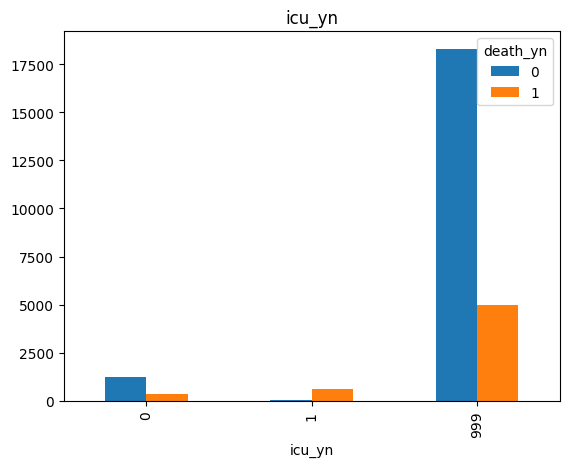

Stacked bar plot: 


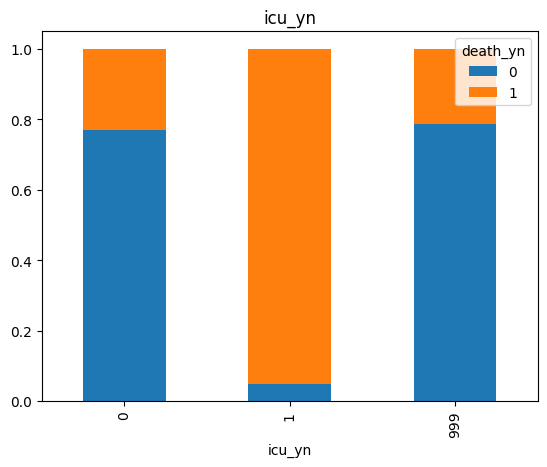

underlying_conditions_yn
Bar Plot: 


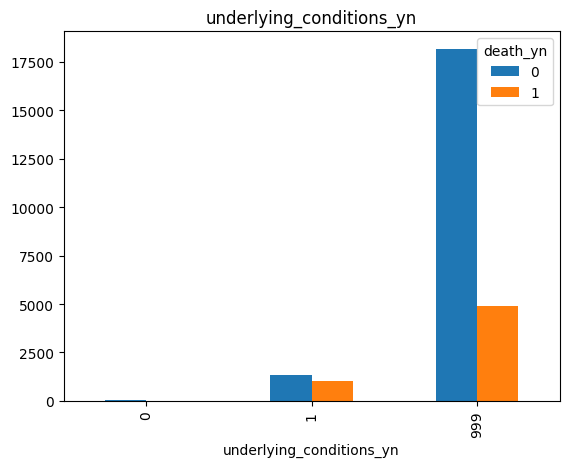

Stacked bar plot: 


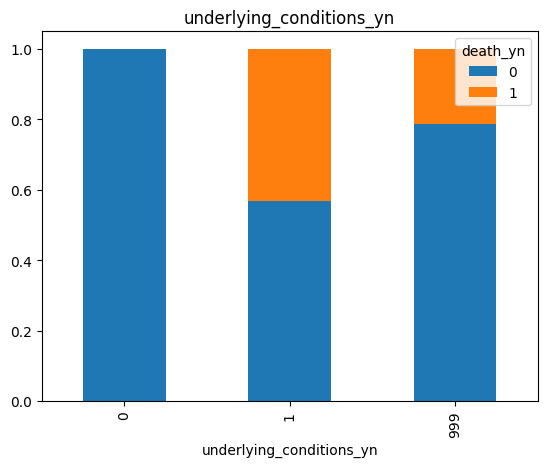

In [22]:
# for the comparison we will convert the target back to categorical
y_train = y_train.astype("category")

# we will create temp dataframe for these plots, mergeing X_train and y_train
df_temp= pd.concat([X_train, y_train], axis=1)

# for each categorical feature create a stacked bar plot
for categorical_feature in categorical_columns:

    print(categorical_feature)

    pd.crosstab(index=df_temp[categorical_feature],columns=df_temp['death_yn']).plot.bar()
    print("Bar Plot: ")
    plt.title(categorical_feature)
    plt.show()

    #seeing the ratio/perfcentage of each unique data category
    percentagecrossx2 = pd.crosstab(df_temp[categorical_feature], df_temp['death_yn']).apply(lambda r: r/r.sum(), axis=1)
    percentagecrossx2.plot.bar(stacked=True, title = "xxx")
    print("Stacked bar plot: ")
    plt.title(categorical_feature)
    plt.show()

#### Interpretation of the results

##### 1. Death vs Age Group
- The missing data category is less significant in this data.
- There is an obvious trends for people with higher age group that has higher death risk, where age 65+ years old has over 50% death.
- We can say that age group has a significant effect on death.

##### 2. Death vs Sex
- The missing data category is less significant in this data.
- There is no obvious death discovered in any of the category of male or female.
- Thus, we can say that sex has less significant effect on death.

##### 3. Death vs Race
- recall that the numeric data are {'Multiple/Other': 1, "Asian": 2, "White" : 3, "Black": 4, "American Indian/Alaska Native": 5, "Native Hawaiian/Other Pacific Islander": 6, "Missing": 999})
- There is no obvious death discovered in any of the category of the races.
- Thus, we can say that race has less significant effect on death.

##### 4. Death vs Ethnicity
- recall that the numeric data are: Non-Hispanic/Latino': 1, "Hispanic/Latino": 2, "Missing": 999
- There is no obvious death discovered in any of the category of the ethnicity.
- Thus, we can say that ethnicity has less significant effect on death.

##### 5. Death vs Current Status
- There is no obvious death discovered in any of the category of current status.
- Thus, we can say that current status has less significant effect on death.

##### 6. Death vs Hospitalisation
- recall that the numeric features are 'Yes': 1, "No": 0, 'Missing: 999.
- There a portion of missing data in this feature, but not too significant thus we will not say that the missing data will affect the result.
- There is an obvious death rate observed for yes in hospitalisation (over 80%).
- We can say that hosp_yn has a significant effect on death.

##### 7. Death vs ICU
- recall that the numeric features are 'Yes': 1, "No": 0, 'Missing: 999.
- There is a significant portion of missing data in this feature,
- There is an obvious death rate observed for yes in icu (over 90%).
- We can say that icu_yn has a significant effect on death.

##### 8. Death vs Underlying Conditions
- recall that the numeric features are 'Yes': 1, "No": 0, 'Missing: 999.
- There is a significant portion of missing data in this feature,
- There is an obvious death pattern observed for yes in underlying conditions, and no death in cases with no underlying conditions.
- We can say that underlying_conditions_yn has an effect on death.

**The categorical features that has less effect are sex, race, ethnicity and current_status**, but for now we will keep all of the categorical features.

### 1.2.4 Summary & Drop Features

1. From Categorical vs Target plots (1.2.3) we identified the following to be dropped:

In [23]:
# drop selected low relevant features
to_be_dropped

['case_month', 'county_fips_code']

Dropping the features:<br> We will drop from a copy of the original dataframe (df_cop1), as this will allow us to revert to the original dataset to compare the performance of the reduced dataset and the original dataset.

In [24]:
# before dropping make copy of original
df_cop1 = df.copy()
# drop low value features
df_cop1.drop(to_be_dropped, axis=1, inplace=True)
print('\nRemaining columns:', df_cop1.columns)
print('\nNew shape:', df_cop1.shape)


Remaining columns: Index(['age_group', 'sex', 'race', 'ethnicity', 'current_status', 'hosp_yn',
       'icu_yn', 'death_yn', 'underlying_conditions_yn'],
      dtype='object')

New shape: (36421, 9)


## 1.3 Preparing Dataset for Modelling
Converting the categorical features into dummies variables, then set up a train and test set. The continuous columns are:

We will use the df_cop1 dataset.

In [25]:
df_cop1

,age_group,sex,race,ethnicity,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,4,Female,1,1,Laboratory-confirmed case,1,999,1,999
1,2,Male,2,1,Laboratory-confirmed case,1,1,1,1
2,4,Female,3,1,Laboratory-confirmed case,999,999,1,999
3,4,Male,3,1,Probable Case,999,999,1,999
4,4,Male,3,1,Laboratory-confirmed case,0,999,1,1
...,...,...,...,...,...,...,...,...,...
36416,4,Male,3,1,Laboratory-confirmed case,999,999,0,999
36417,2,Male,4,999,Laboratory-confirmed case,999,999,0,999
36418,2,Male,3,1,Laboratory-confirmed case,0,999,0,999
36419,2,Male,3,1,Laboratory-confirmed case,0,999,0,999


In [26]:
df_cop1.dtypes

age_group                   category
sex                         category
race                        category
ethnicity                   category
current_status              category
hosp_yn                     category
icu_yn                      category
death_yn                       int64
underlying_conditions_yn    category
dtype: object

All selected features are categorical

In [27]:
# set up dummies features
df_cop1 = pd.get_dummies(df_cop1)
df_cop1.dtypes

death_yn                                    int64
age_group_1                                 uint8
age_group_2                                 uint8
age_group_3                                 uint8
age_group_4                                 uint8
age_group_999                               uint8
sex_Female                                  uint8
sex_Male                                    uint8
sex_Missing                                 uint8
race_1                                      uint8
race_2                                      uint8
race_3                                      uint8
race_4                                      uint8
race_5                                      uint8
race_6                                      uint8
race_999                                    uint8
ethnicity_1                                 uint8
ethnicity_2                                 uint8
ethnicity_999                               uint8
current_status_Laboratory-confirmed case    uint8


In [28]:
features = df_cop1.select_dtypes(include=['uint8']).columns.tolist()
features

['age_group_1',
 'age_group_2',
 'age_group_3',
 'age_group_4',
 'age_group_999',
 'sex_Female',
 'sex_Male',
 'sex_Missing',
 'race_1',
 'race_2',
 'race_3',
 'race_4',
 'race_5',
 'race_6',
 'race_999',
 'ethnicity_1',
 'ethnicity_2',
 'ethnicity_999',
 'current_status_Laboratory-confirmed case',
 'current_status_Probable Case',
 'hosp_yn_0',
 'hosp_yn_1',
 'hosp_yn_999',
 'icu_yn_0',
 'icu_yn_1',
 'icu_yn_999',
 'underlying_conditions_yn_0',
 'underlying_conditions_yn_1',
 'underlying_conditions_yn_999']

### Setting up the train/test split
- Setting up data based on the updated dummy values, and stored in dataframe X.
- The Target (death_yn) is stored in dataframe "y"

In [29]:
# y is the target
y = df_cop1["death_yn"]

# X is everything else
X = df_cop1.drop(["death_yn"],axis=1)

# Split the dataset into two datasets: 70% training and 30% test, randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

print("original range is: ",df_cop1.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0] ) + X_test.shape[0])

original range is:  36421
training range (70%):	 rows 0 to 25494
test range (30%): 	 rows 25494 to 36421


In [30]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", y_train.head(5))


Descriptive features in X:
        age_group_1  age_group_2  age_group_3  age_group_4  age_group_999  \
34394            1            0            0            0              0   
19675            0            0            0            1              0   
31126            0            1            0            0              0   
34306            0            1            0            0              0   
33790            0            1            0            0              0   

       sex_Female  sex_Male  sex_Missing  race_1  race_2  ...  \
34394           1         0            0       0       0  ...   
19675           0         1            0       0       0  ...   
31126           0         0            1       0       0  ...   
34306           1         0            0       0       0  ...   
33790           1         0            0       0       1  ...   

       current_status_Probable Case  hosp_yn_0  hosp_yn_1  hosp_yn_999  \
34394                             0          0   

Resetting the index of all training and test dataframe so that index is consecutive to enable the smooth merging of dataframes in the coming sections

In [31]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,age_group_1,age_group_2,age_group_3,age_group_4,age_group_999,sex_Female,sex_Male,sex_Missing,race_1,race_2,...,current_status_Probable Case,hosp_yn_0,hosp_yn_1,hosp_yn_999,icu_yn_0,icu_yn_1,icu_yn_999,underlying_conditions_yn_0,underlying_conditions_yn_1,underlying_conditions_yn_999
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1
2,0,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,1,0,0,1
3,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
4,0,1,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1


The datasets are now ready for modelling.

# Part 2: Linear Regression Model

##  2.1 On the training set, train a linear regression model to predict the target feature

In [32]:
# Train a multiple linear regression model with all features
multiple_linreg = LinearRegression().fit(X_train, y_train)

##  2.2 Coefficients learned by the model

### 2.2.1 Printing the coefficients

In [33]:
# Print the weights learned for each feature used for the model
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_linreg.coef_)
print("\nIntercept is: \n", multiple_linreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_linreg.coef_)))


Features are: 
 Index(['age_group_1', 'age_group_2', 'age_group_3', 'age_group_4',
       'age_group_999', 'sex_Female', 'sex_Male', 'sex_Missing', 'race_1',
       'race_2', 'race_3', 'race_4', 'race_5', 'race_6', 'race_999',
       'ethnicity_1', 'ethnicity_2', 'ethnicity_999',
       'current_status_Laboratory-confirmed case',
       'current_status_Probable Case', 'hosp_yn_0', 'hosp_yn_1', 'hosp_yn_999',
       'icu_yn_0', 'icu_yn_1', 'icu_yn_999', 'underlying_conditions_yn_0',
       'underlying_conditions_yn_1', 'underlying_conditions_yn_999'],
      dtype='object')

Coeficients are: 
 [ 1.77577674e+10  1.77577674e+10  1.77577674e+10  1.77577674e+10
  1.77577674e+10  1.36509825e+11  1.36509825e+11  1.36509825e+11
  9.70804404e+10  9.70804404e+10  9.70804404e+10  9.70804404e+10
  9.70804404e+10  9.70804404e+10  9.70804404e+10 -2.48709808e+11
 -2.48709808e+11 -2.48709808e+11  5.72657714e+11  5.72657714e+11
 -1.41822864e+11 -1.41822864e+11 -1.41822864e+11  4.79283706e+10
  4.792837

### 2.2.2  Interpreting the Linear Regression Model

- Linear Regression (Linear Regression) is a model used to establish a linear relationship between variables, which assumes that there is a linear relationship between the dependent variable (or response variable) and the independent variable (or predictor variable), i.e. a straight line can be fitted to the data.
    - A linear regression model seeks a straight line (the best fit line) that best fits the connection between input and output variables. The goodness of fit can be calculated by comparing the expected and actual results.
    - The least squares method is commonly used to find the best-fitting straight line by minimizing the sum of squares of residuals between predicted and true values.
- The linear regression formula takes the following form:
    - $target\_feature = w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n $
    - target_feature is the dependent variable we are trying to predict
- We can see the calculated intercept is 4270730587103.7144 (w_0).
    - This is the starting point. i.e. if all other coefficients are zero (if there is no record present for the case and all category are marked 0) then the model result will be 4270730587103.7144, which is the y-axis of the model.
- For the coefficients for each feature, the sum of all the feature*coefficients + intercept will result in the model prediction.
- The coefficients of each features cannot be compared directly as it is tied directly to the range of each feature. 
- A positive correlation means that the feature will impact the target prediction positively. A negative correlation means that the if the feature increases, it will affect the target feature negative, which makes the target feature value decreases.
<br><br>

#### Observation and Discussion:
Linear Regression model is not suitable for the classification problem that we are trying to solve, especially with all categorical features. - The output is not a probability and an additional thresholding step is necessary to convert the output into a binary classification, as all values >= 0.5 will be cast to 1, and any < 0.5 will be cast to 0. <br><br>
For our linear model, there is a huge y-intercept value of 4270730587103.7144, perhaps due to the presence the majority of data is missing in the dataset, which is denoted to 999. We will accept missing as a data category in this case.<br><br>
reference from example given for homework2


### 2.3  Print the predicted target feature value for the first 10 training examples and evaluate the prediction

- Here we will print the predicted target feature value for the first 10 training examples. 
- We will threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. 
    - If value is >= 0.5 it is cast to 1, if < 0.5 it is cast to 0

In [34]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_train = (multiple_linreg.predict(X_train) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   death_yn  Predicted
0         0        0.0
1         1        1.0
2         0        0.0
3         0        0.0
4         0        0.0
5         1        0.0
6         1        1.0
7         0        0.0
8         0        0.0
9         0        0.0


- We will print a few classification evaluation measures computed on the full training set
- We will discuss our findings base on these measures.

In [35]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.908605946497215
Confusion matrix: 
 [[18488  1068]
 [ 1262  4676]]
Classification report:
                precision    recall  f1-score   support

           0       0.94      0.95      0.94     19556
           1       0.81      0.79      0.80      5938

    accuracy                           0.91     25494
   macro avg       0.88      0.87      0.87     25494
weighted avg       0.91      0.91      0.91     25494



### Interpretation of Results ( 1 = death, 0 = non-death)
- Accuracy
    - Accuracy is the percentage of samples properly classified by the classification model to the total number of samples. We have an accuracy of 90.8%.
- Confusion Matrix
    - [0][0] - TN (True Negative) indicates the number of samples that are genuinely non-death and correctly identifiedby the model. - The number that is predicted 0 that is actually 0.
    - [0][1] - FP (False Positive) indicates the number of samples that are truly non-death but are wrongly labeled as death by the model. - The number that is predicted 1 that is actually 0. 
    - [1][0] - FN (False Negative) indicates the number of samples that are truly death but are wrongly labeled as non-death by the model. - The number that is predicted 0 that is actually 1
    - [1][1] - TP (True Positive) indicates the number of samples that are genuinely death and correctly identifiedby the model. - The number that is predicted 1 that was actually 1
    
- Precision - Precision is the percentage of samples for which the model actually predicts positive cases.
    - Precision Positive is 0.81 - The percentage of predicted death values that actually has death.
    - Precision Negative is 0.94 - The percentage of predicted non-death values that actually has non-death

- Recall - Is the number correctly predicted positive over the total number actual positive
    - Recall Positive is 0.78 - How many of the death cases were correctly predicted.
    - Recall Negative is 0.95 - How many of the non-death cases were predicted correctly.

- F1 Score - Is an a weighted average of Precision and recall
    - F1 Score Positive is 0.80
    - F1 Score Negative is 0.94
  
Summary
- These values seem reasonable. 
- The model is a better at predicting the negative class(non-death).
- This makes sense as the model has more negative data to learn from - it is the majority class(non-death).
- This is ideal because it can flag potentially cured (surviving) patients more accurately.
- The down side of this is more people who will not actually dead will be flagged

### 2.4  Evaluation metrics based on training data
- We will using classification evaluation measures on the hold-out (30% examples) test set
- Compare these results with the evaluation results obtained on the training (70%) dataset. Also compare these results with a cross-validated model.
- We will discuss findings based on these measures

Printing Actual death_yn vs predicted based on test data

In [36]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_test = (multiple_linreg.predict(X_test) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   death_yn  Predicted
0         0        0.0
1         0        0.0
2         0        0.0
3         1        0.0
4         0        0.0
5         0        0.0
6         0        0.0
7         0        0.0
8         0        0.0
9         0        0.0


##### Evaluation metrics based on test data

In [37]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_linreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_linreg_predictions_test))
print("Classification report - Test data:\n ", metrics.classification_report(y_test, multiple_linreg_predictions_test))
print("\n==================== Train Data ======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("\nClassification report: - Training data\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))

==================== Test Data =======================
Accuracy:  0.9092157042189073
Confusion matrix: 
 [[7884  456]
 [ 536 2051]]
Classification report - Test data:
                precision    recall  f1-score   support

           0       0.94      0.95      0.94      8340
           1       0.82      0.79      0.81      2587

    accuracy                           0.91     10927
   macro avg       0.88      0.87      0.87     10927
weighted avg       0.91      0.91      0.91     10927


==================== Train Data ======================
Accuracy:  0.908605946497215
Confusion matrix: 
 [[18488  1068]
 [ 1262  4676]]

Classification report: - Training data
                precision    recall  f1-score   support

           0       0.94      0.95      0.94     19556
           1       0.81      0.79      0.80      5938

    accuracy                           0.91     25494
   macro avg       0.88      0.87      0.87     25494
weighted avg       0.91      0.91      0.91     25494


**Interpretation of test results and comparison with training results**
- Accuracy
    - The accuracy of the test data is marginally higher than the train data, 90.92% vs 90.86%. 
- Precision
    - The precision score for predicting the positive case has increased from 81% to 82%.
    - The precision score for predicting the negative case has reduced from 94% to 93%.
- Recall
    - The recall score for predicting the positive case has increased from 78% to 79%.
    - The recall score for predicting the negative case has remains unchanged at 95%.
- F1 Score
    - The f1 score for predicting the positive case has remains unchanged at 80%.
    - The f1 score for predicting the negative case has remains unchanged at 94%.
    
**Summary**
- On the test data, the model's accuracy improved slightly, while the precision and recall varied slightly but not significantly in the positive and negative categories, respectively, and the f1 score remained unchanged.
- This suggests that the model predicts the test results well overall, but has slightly varied prediction ability for both positive and negative categories, which requires additional investigation and adjustment.
- It should be emphasized that this is merely an evaluation of the results of a single training and testing session, and that model evaluation and comparison utilizing techniques such as cross-validation are required to obtain more trustworthy model evaluation findings.

### 2.5 Cross Validation
First we need to create a function to perform this cross validation. 

In [38]:
def cross_val_LinReg(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        # threshold
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= 0.5) * 1.0
        # calc score
        if scoring=='accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='f1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        # append to results
        results.append(score)
    return results

In [39]:
def cross_val_LinReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    
    return LinRegDF

Preform 10 fold cross validation using cross_val_LinReg_DF function
- Results summarised below

In [40]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
linRegDF

Mean results from 10 fold cross validation are:


,Linear_Regression
accuracy,0.906964
precision,0.808917
recall,0.787534
f1,0.797883


These results are marginally lower than previous results, which is not surprising given that they are the average of 10 sets of results. Because there may be some randomness in the division of the data set, initialization parameters, etc., the results obtained from multiple training sessions may also vary.

## Part 3: Logistic Regression Model

### 3.1  Train a logistic regression model

In [41]:
# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg = LogisticRegression().fit(X_train, y_train)

##  3.2 Coefficients learned by the model

### 3.2.1 Printing the coefficients

In [42]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_logisticreg.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_logisticreg.coef_[0])))


Features are: 
 Index(['age_group_1', 'age_group_2', 'age_group_3', 'age_group_4',
       'age_group_999', 'sex_Female', 'sex_Male', 'sex_Missing', 'race_1',
       'race_2', 'race_3', 'race_4', 'race_5', 'race_6', 'race_999',
       'ethnicity_1', 'ethnicity_2', 'ethnicity_999',
       'current_status_Laboratory-confirmed case',
       'current_status_Probable Case', 'hosp_yn_0', 'hosp_yn_1', 'hosp_yn_999',
       'icu_yn_0', 'icu_yn_1', 'icu_yn_999', 'underlying_conditions_yn_0',
       'underlying_conditions_yn_1', 'underlying_conditions_yn_999'],
      dtype='object')

Coeficients are: 
 [-3.54885080e+00 -1.54251780e+00  6.87217331e-01  3.38404152e+00
  8.79689805e-01 -6.97436126e-02  2.98133525e-01 -3.68809865e-01
 -1.40417229e+00  7.62053134e-01  2.05071650e-02  7.53355430e-02
  6.85431242e-01 -7.58065955e-02 -2.03768155e-01 -1.36807433e-01
  1.03760166e+00 -1.04121418e+00 -1.39297763e-01 -1.12219033e-03
 -1.49100622e+00  1.68251319e+00 -3.31926926e-01 -1.27406523e+00
  1.582784


For both linear regression and logistic regression, the first step is to find the best-fit curve or hyperplane to describe the data
- Linear regression is used to predict the relationship between continuous variables with a straight line that minimizes the mean squared error.

- Logistic regression is used to predict the relationship between discrete variables with a curve that minimizes the difference between predicted and true values. For logistic regression, we pass the equation through a sigmoid function that produce output value between 0 to 1, which is in probability terms. Same as the previous linear model, thelogistic model then applies a threshold to this probability so that if is is >= 0.5 its cast to 1 and if it is <0.5 it is cast to 0. Logistic Regression models are not much impacted due to the presence of outliers because the sigmoid function tapers the outliers. (reference from https://medium.com/geekculture/essential-guide-to-handle-outliers-for-your-logistic-regression-model-63c97690a84d#:~:text=Logistic%20Regression%20models%20are%20not,model%20and%20lowering%20the%20performance.)

- The Logistic regression formula takes the following form:
    - $probability(target=1|descriptive\_features)=logistic(w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n)$
 
- From the values above can see the calculated y-intercept is -1.794.
    - This is the reference point, assuming all other coefficients are zero (when the record for the case is empty and all category are marked 0), where the value of 'y' is equal to -1.794.
    - For our intercept which is a negative sign, then the probability of having the outcome will be less than 0.5. (reference https://quantifyinghealth.com/interpret-logistic-regression-intercept/)
    
Logistic regression can handle discrete or categorical outcomes and provides a probability estimate for each predicted outcome, making it easier to interpret results and make predictions. It is less sensitive to outliers than linear regression, which makes their impact on the model is minimal. In this case when comparing both the linear and logistic regression, the logistic regression is better for our problem domain here as all our features selected here are categorical (non-continuous). 

### 3.3  Evaluate the Metrics based on Training data

- Here we will print the predicted target feature value for the first 10 training examples. 
- We will Print a few classification evaluation measures computed on the full training set.

#### 3.3.1 Printing the predicted target feature value for the first 10 training examples

In [43]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_train = multiple_logisticreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_train, pd.DataFrame(multiple_logisticreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(10))


Predictions with multiple linear regression: 

   death_yn  Predicted
0         0          0
1         1          1
2         0          0
3         0          0
4         0          0
5         1          0
6         1          1
7         0          0
8         0          0
9         0          0


#### 3.3.2 Evaluation Metrics

In [44]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9089197458225465
Confusion matrix: 
 [[18591   965]
 [ 1357  4581]]
Classification report:
                precision    recall  f1-score   support

           0       0.93      0.95      0.94     19556
           1       0.83      0.77      0.80      5938

    accuracy                           0.91     25494
   macro avg       0.88      0.86      0.87     25494
weighted avg       0.91      0.91      0.91     25494



#### 3.3.3 Interpretation of results( 1 = death, 0 = non-death)
- Accuracy
    - Accuracy is the percentage of samples properly classified by the classification model to the total number of samples. We have an accuracy of 90.89%.
    
- Precision - Precision is the percentage of samples for which the model actually predicts positive cases.
    - Precision Positive is 0.83 - The percentage of predicted death values that actually did death.
    - Precision Negative is 0.93 - The percentage of predicted non-death values that actually did non-death

- Recall - Is the number correctly predicted positive over the total number actual positive
    - Recall Positive is 0.77 - How many of the death cases were correctly predicted.
    - Recall Negative is 0.95 - How many of the non-death cases were predicted correctly.

- F1 Score - Is an a weighted average of Precision and recall
    - F1 Score Positive is 0.80
    - F1 Score Negative is 0.94
  
<b>Summary</b>
- Theses values seem reasonable. 
- Slightly higher accuracy than linear regression model.
- The logistic model is also a better at predicting the negative class.
- This makes sense as the model has more negative data to learn from - it is the majority class(non-death).

### 3.4  Evaluation based on Test Set
- We will using classification evaluation measures on the hold-out (30% examples) test set
- Compare these results with the evaluation results obtained on the training (70%) dataset. Also compare these results with a cross-validated model.
- We will discuss findings based on these measures

#### 3.4.1 Printing the predicted target feature value for the first 10 test data

In [45]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test = multiple_logisticreg.predict(X_test)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_test, pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(10))


Predictions with multiple linear regression: 

   death_yn  Predicted
0         0          0
1         0          0
2         0          0
3         1          0
4         0          0
5         0          0
6         0          0
7         0          0
8         0          0
9         0          0


#### 3.3.2 Evaluation Metrics 
(on test data and printing out metrics on training dataset for comparison)

In [46]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_logisticreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_logisticreg_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, multiple_logisticreg_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9104969341996888
Confusion matrix: 
 [[7936  404]
 [ 574 2013]]
Classification report:
                precision    recall  f1-score   support

           0       0.93      0.95      0.94      8340
           1       0.83      0.78      0.80      2587

    accuracy                           0.91     10927
   macro avg       0.88      0.86      0.87     10927
weighted avg       0.91      0.91      0.91     10927

==================== Train Data =======================
Accuracy:  0.9089197458225465
Confusion matrix: 
 [[18591   965]
 [ 1357  4581]]
Classification report:
                precision    recall  f1-score   support

           0       0.93      0.95      0.94     19556
           1       0.83      0.77      0.80      5938

    accuracy                           0.91     25494
   macro avg       0.88      0.86      0.87     25494
weighted avg       0.91      0.91      0.91     25494



#### 3.4.3 Interpretation of test results and comparison with training results( 1 = death, 0 = non-death) 

- Accuracy
    - The accuracy of the test data is marginally higher 91.04% vs 90.89%. 
- Precision
    - The precision score for predicting the positive case has remains unchanged at 83%.
    - The precision score for predicting the negative case has remains unchanged at 93%.
- Recall
    - The recall score for predicting the positive case has increased from 77% to 78%.
    - The recall score for predicting the negative case has remains unchanged at 95%.
- F1 Score
    - The f1 score for predicting the positive case has remains unchanged at 80%.
    - The f1 score for predicting the negative case has remains unchanged at 94%.
    
**Summary**
- The accuracy of the test data increased slightly from the previous result of 90.89% to 91.04%.
- The model shows promising overall performance on the test data, but some variance in predicting both positive and negative categories suggests the need for further investigation and fine-tuning.
- This highlights the need for further model evaluation and comparison, which can be achieved through the use of cross-validation

### 3.5 Cross Validation

In [47]:
def cross_val_LogReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults[metric] = result.mean()
        
    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

Preform 10 fold cross validation using cross_val_LogReg_DF function
- Results summarised below

In [48]:
logRegDF = cross_val_LogReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
logRegDF

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.909036
precision,0.824854
recall,0.776418
f1,0.799792


These results are marginally lower than previous results. This is reasonable. Cross-validation assesses the model's performance by employing various subsets of data as training and test sets. This may produce slightly poorer results than single training and test sets, but it can increase the model's generalization.

## Part 4: Random Forest Model

### 4.1 Training a Random Forest Model
A random forest model will now be trained on our test data based on the descriptive features selected from part one. In our case, all features are descriptive, thus all features are selected. We will use the RandomForestClassifier() function. 

In [49]:
rfc = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=1)

### 4.2 Interpreting the Random Forest model
We will now try to understand how this random forest model works
- A random forest is made up of a collection of decision trees
- Decision tree
    - A decision tree is a set of if-then-else rules based on splitting the data based on specific features until no split is possible/ until the maximum depth is reached
    - The decision on which feature to split on is based on the information gain (Gini index). 
    - The tree will always split on the feature that gives the highest information gain
    - The feature with the highest information gain will sit at the root of each decision tree
    - Each decision tree will be a single prediction
- Random Forest 
    - The random forest is made up of a number of decision trees, and the output is the  majority output of all decision trees combined
    - The random forest will rank the features based on the importance of features in terms of information gain

####  4.2.1  Example: Train Decision tree
We will train 2 decision trees, with the same test data to see how a decision tree work
- One with max_depth=3 and the other max_depth=6
- Max depth determines how deep a decision tree can go before it must give an answer

In [50]:
dtc3 = DecisionTreeClassifier(max_depth=3, random_state=1)
dtc6 = DecisionTreeClassifier(max_depth=6, random_state=1)
dtc3.fit(X_train, y_train)
dtc6.fit(X_train, y_train)
print("Max depth 3: \n",dtc3)
print("Max depth 6: \n",dtc6)

Max depth 3: 
 DecisionTreeClassifier(max_depth=3, random_state=1)
Max depth 6: 
 DecisionTreeClassifier(max_depth=6, random_state=1)


####  4.2.2  Example: Displaying Decision tree

In [51]:
# create a Graphviz png
with open("DecisionTree3.dot", 'w') as f1:
    f1 = export_graphviz(dtc3, out_file=f1, feature_names=X_train.columns)

with open("DecisionTree6.dot", 'w') as f2:
    f2 = export_graphviz(dtc6, out_file=f2, feature_names=X_train.columns)

!dot -Tpng DecisionTree3.dot -o DecisionTree3.png
!dot -Tpng DecisionTree6.dot -o DecisionTree6.png

We can see below the decision tree with maximum depth 3: 
- We can see the root is age_group_4 ，= 0.5 - This splits the data best i.e. has the highest information gain
- For each split the the model selects the next best feature, and continues until it reaches a leaf node where the data cannot be split anymore
- The output of this is the prediction

<img src="DecisionTree3.png">

Below shows visualisation of a decision tree with maxdepth=6 shows how complicated this model becomes as the maximum depth increases. A Random forests has 100 decision trees by default (based on the scikit-learn.org documentation). Each decision tree is given a slightly different view of the data to model.

<img src="DecisionTree6.png">

#### 4.2.3 Interpretation of the Random Forest Model
A random forest will keep track of the importance of features, and we can see the below dataframe that shows the feature importance ranking. The more important features are the features that the random forest has identified as having higher information gain.<br>
This list is the combined result of the 100 decision trees that make up the random forest model. This will help us in our model optimisation process to determine which are the best features to keep and which features could be dropped.

In [52]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
3,age_group_4,3.582727e-01
21,hosp_yn_1,2.518092e-01
1,age_group_2,1.067476e-01
20,hosp_yn_0,6.656099e-02
0,age_group_1,3.007029e-02
22,hosp_yn_999,2.725904e-02
2,age_group_3,2.446647e-02
17,ethnicity_999,2.292460e-02
24,icu_yn_1,2.232054e-02
15,ethnicity_1,1.073008e-02


A graph is plot to visualise the importance ranking:

Text(0.5, 0, 'Random Forest Feature Importance')

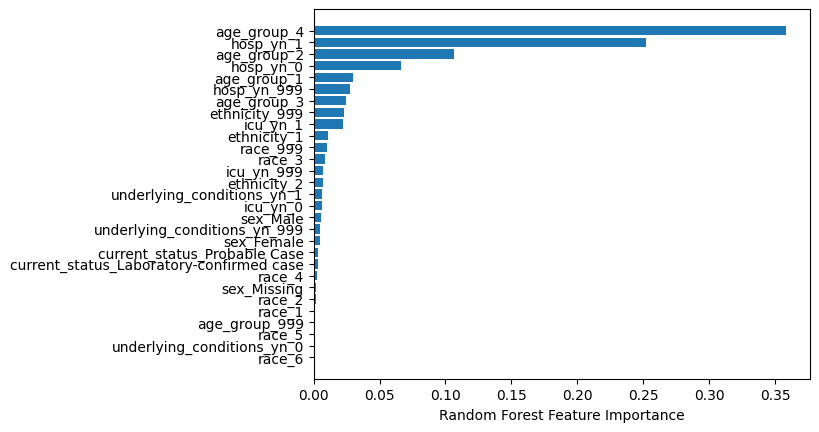

In [53]:
sorted_idx = rfc.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

We can see that the two features age_group, hosp_yn has high ranking in feature importance.

### 4.3 Evaluation using same Train Set 
we will use the first 100 Training Examples

#### 4.3.1 Printing the Predicted Target Feature Value and Predicted Class

In [54]:
# Predicted class labels for all examples, 
# using the trained model, same sample used for training and test

rfc_predictions_train = rfc.predict(X_train)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_predictions_train})
df_true_vs_rfc_predicted.head(100)

,ActualClass,PredictedClass
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0
...,...,...
95,0,0
96,0,0
97,0,0
98,0,0


#### 4.3.2 Evaluation based on Training Set

In [55]:
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))

==================== Train Data =======================
Accuracy:  0.9155487565701734
Confusion matrix: 
 [[18535  1021]
 [ 1132  4806]]
Classification report:
                precision    recall  f1-score   support

           0       0.94      0.95      0.95     19556
           1       0.82      0.81      0.82      5938

    accuracy                           0.92     25494
   macro avg       0.88      0.88      0.88     25494
weighted avg       0.92      0.92      0.92     25494



<b>Observation and Discussion: </b> <br><br>
There is a high accuracy as the model has learnt the result on the same test set. There might be possibility of overfitting, which we will examine below.

### 4.4 Evaluation using Test Set
we will evaluate the model using classification evaluation measures on the hold-out (30% examples) test set, and them compare the results from the training data. In addition the results will also be compared from a cross-validated model, which is a new model trained and evaluated using cross-validation on the full dataset.

#### 4.4.1 Printing the Predicted Target Feature Value and Predicted Class on test dataset:

In [56]:
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(20)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,1,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,1
9,0,1


#### 4.4.2 Evaluation metrics based on test data

In [57]:
print("********************** Test Data **********************")
print("Accuracy: ", metrics.accuracy_score(y_test, rfc_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, rfc_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, rfc_predictions_test))


print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))

********************** Test Data **********************
Accuracy:  0.9126933284524572
Confusion matrix: 
 [[7910  430]
 [ 524 2063]]
Classification report:
                precision    recall  f1-score   support

           0       0.94      0.95      0.94      8340
           1       0.83      0.80      0.81      2587

    accuracy                           0.91     10927
   macro avg       0.88      0.87      0.88     10927
weighted avg       0.91      0.91      0.91     10927

==================== Train Data =======================
Accuracy:  0.9155487565701734
Confusion matrix: 
 [[18535  1021]
 [ 1132  4806]]
Classification report:
                precision    recall  f1-score   support

           0       0.94      0.95      0.95     19556
           1       0.82      0.81      0.82      5938

    accuracy                           0.92     25494
   macro avg       0.88      0.88      0.88     25494
weighted avg       0.92      0.92      0.92     25494



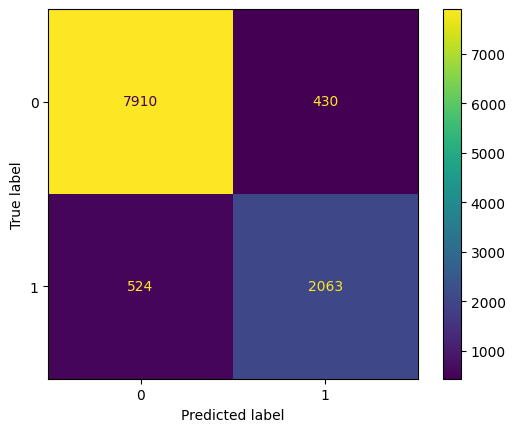

In [58]:
#A visualisation of the confusion matrix for the test data
ConfusionMatrixDisplay(confusion_matrix(y_test, rfc_predictions_test)).plot()

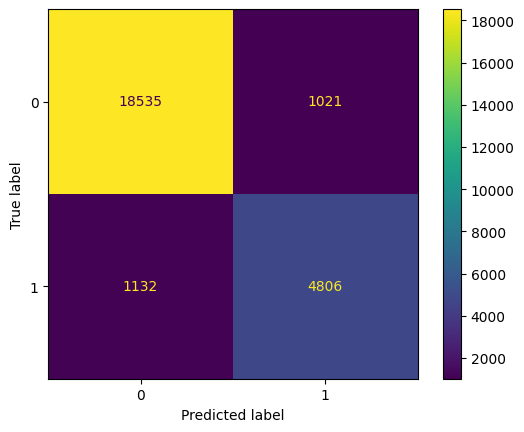

In [59]:
#A visualisation of the confusion matrix for the train data
ConfusionMatrixDisplay(confusion_matrix(y_train, rfc_predictions_train)).plot()


<b>Observation and Discussion: </b> <br><br>

Interpretation of test result and comparison with training results: (1 = Death = Positive, 0 = Non-death = Negative)
- <b>Confusion matrix</b> is shown in the format where <br><br>[0][0] = True Negative, is where predicted non-death is actual non-death
<br>[1][1] = True Positive, is where the predicted death is actual death; <br>
[0][1] = False Positive, is where predicted death is actual non-death; <br>
[1][0] = False Negative, is where predicted non-death is actually death.<br>From the confusion matrix above, both True Positive and True Negative value are higher than false positive and false negative, meaning the the model is giving high percentatge of accurate prediction.<br><br>
- <b>Precision</b> means the percentage of correct positive predictions relative to total positive predictions. In this case, for both the train and test data, out of all the cases that the model predicted would have death, 83% (test)/ 82% (train) actually did.
- <b>Recall</b> In this case, for both the train and test data, out of all the cases that actually have death, 80% (test)/ 81% (train) actually did. 
- <b>F1 score</b> is a weighted harmonic mean of precision and recall. The closer to 1, the better the model. Both for test and train dataset validation, the f1 score is about 0.8 which is quite close to 1, meaning that this is a relatively good model.
- <b>Support</b> simply shows that how many cases belonged to each outcome (death/ no-death) in the dataaset.
<br>
<br>
- The accuracy for the 30% test data (out-of-sample data) is pretty much similar to the model result for the train data (70% of the data).
- The scores seem reasonable and are in line with the other model test results, which means the model has high accuracy, this could mean that the model is not overfitting as the accuracy are consistent.

<br><br> reference from https://www.statology.org/sklearn-classification-report/, https://www.jcchouinard.com/confusion-matrix-in-scikit-learn/

#### 4.4.3 Evaluation with Cross Validation
Performing cross valudation and store the result for later evaluation uses.


In [60]:
#this cross validation function is reference from example answer for COMP47350 Assignment2
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

Cross Validate the Random Forest Model

In [61]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,0.910903
precision,0.819009
recall,0.795188
f1,0.806840


<b>Observation and Discussion: </b> <br><br>

- The accuracy obtained from the cross validation result is the same as the result from evaluation with train and test dataset, with approx 91% accuracy.
- <b>Precision</b> is pretty similar to the model validating with train/test data, with approximately 80%. 
- <b>Recall</b> is pretty similar to the model validating with train/test data, with approximately 80%. 
- For <b>F1 score</b> the closer to 1, the better the model. This is also consistent with the train/test data validation, meaning that this is a relatively good model.
- In summary, three different validation provides consistent evaluation report of the mode, proving that the model is not overfitting/ underfitting.

#### 4.4.4 Evaluation with OOB Score
A OOB Score (Out-of-Bag Score) is computed as the number of correctly predicted rows from the OOB sample, which is data that are not used in the training model, and would provide an unbiased estimate of the model's performance. (source: https://www.geeksforgeeks.org/oob-errors-for-random-forests-in-scikit-learn/). It is used as an additional measure and should be line with the cross validation results


In [62]:
# compute the out-of-bag classification accuracy
print("OOB error:", rfc.oob_score_)

OOB error: 0.9099788185455401


<b>Observation and Discussion: </b> <br><br>

The OOB score above shows 0.9, giving an accuracy very similar but lower to the previous validation. This shows that the accuracy of our previous model is consistent and high. This extra score supports the consistency on evaluation report of the model, proving that the model is not overfitting/ underfitting.

## Part 5: Improving Predictive Models

### 5.1 Better Performing Model for Predicting the Target Feature
Recall the accuracy for the model below, all of them have a high accuracy of over 90% and their difference is +/- 1%:

In [63]:
ResultsCompare = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsCompare

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.906964,0.909036,0.910903
precision,0.808917,0.824854,0.819009
recall,0.787534,0.776418,0.795188
f1,0.797883,0.799792,0.806840


### 5.2 Is the model more accurate than a simple model that always predicts the majority class
To explore this, we will compare our results above to a simple model which predicts for the majority class. First we need to find the majority class from the test dtaset.

In [64]:
death_count = y_test[y_test == 1].count()
nondeath_count = y_test[y_test == 0].count()
total = death_count + nondeath_count
print(f'From original dataset: \t\tCount {total}')
print(f'Total number of death:\t {death_count}\t{round(death_count/len(y_test)*100,2)}%')
print(f'Total number of non-death:\t {nondeath_count}\t{round(nondeath_count/len(y_test)*100,2)}%')

From original dataset: 		Count 10927
Total number of death:	 2587	23.68%
Total number of non-death:	 8340	76.32%


The majority class is 0, which is non-death. We will now generate scores for predicting the majority class:

In [65]:
# generate array of 10927 zeros (length of test dataset)
majority = np.zeros(10927)

# create dataframe 
df_majorityClass = pd.DataFrame(majority, columns=['prediction'])

# calculate scores of simple prediction vs actual on the majority class
print("Accuracy: ", metrics.accuracy_score(y_test, df_majorityClass))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, df_majorityClass))
print("Classification report:\n ", metrics.classification_report(y_test, df_majorityClass))

Accuracy:  0.7632470028370092
Confusion matrix: 
 [[8340    0]
 [2587    0]]
Classification report:
                precision    recall  f1-score   support

           0       0.76      1.00      0.87      8340
           1       0.00      0.00      0.00      2587

    accuracy                           0.76     10927
   macro avg       0.38      0.50      0.43     10927
weighted avg       0.58      0.76      0.66     10927



Interpretation of the Evaluation Metrics for Simple Prediction for the Majority Class:<br><br>
- As the model only predicts non-death (majority-class), for predicting death this simple model fails completely.
- For predicting non-death, there is a 0.76 accuracy of the model. The model performs but worse than the three model trained above (linear regression, logistic regression, random forest).

### 5.3 Compare Model Performance using Different Features Subsets 

#### 5.3.1 All features
- We will now repeat the tests using all original features

In [66]:
# dataframe with all features = original dataframe (preserved at Part1)

#As there is a datetime object in the original dataframe (case_month), we need to change the datetime data into categorical datatype to fit into the models.
df['case_month'] = df['case_month'].astype('category')

#creating dummies
df_all = pd.get_dummies(df)

# set X,y
y = df_all["death_yn"]
X = df_all.drop(["death_yn"], axis = 1)
print("number of features incl dummies: ", len(X.columns))

number of features incl dummies:  1389


There is a exceptionally high feature numbers due to there are some columns in the original dataframe that is logically not suitable to be used to train the model (eg case month, state code etc.). For optimising the model running time, we will categorise case_month into their respective year (only 3 years worth of data, in my opinion it is too less to make a monthly analysis, thus we chose yearly as the unit).

In [67]:
# #change the datetime format into a string format
df['case_year'] = df['case_month'].dt.strftime("%Y")
df['case_year'] = df['case_year'].astype('category')

In [68]:
df.drop('case_month',inplace=True, axis=1)

In [69]:
#creating dummies
df_all = pd.get_dummies(df)

# set X,y
y = df_all["death_yn"]
X = df_all.drop(["death_yn"], axis = 1)
print("number of features incl dummies: ", len(X.columns))

number of features incl dummies:  1357


We can see that the dummy features reduced to 1357 (from 1389). There is still a large number of columns present. We will explore the unique data entry for each category to see what can be done to reduce the number of frequency, if we want to use all feature. 

In [70]:
df.dtypes

county_fips_code            category
age_group                   category
sex                         category
race                        category
ethnicity                   category
current_status              category
hosp_yn                     category
icu_yn                      category
death_yn                       int64
underlying_conditions_yn    category
case_year                   category
dtype: object

In [71]:
# look at descriptive stats for categorical features only
features = df.select_dtypes(['category']).columns
df_table = df[features].describe().T
df_table

,count,unique,top,freq
county_fips_code,34214.0,1325.0,12086.0,648.0
age_group,36421,5,2,13978
sex,36421,3,Female,18398
race,36421,7,3,22524
ethnicity,36421,3,1,21980
current_status,36421,2,Laboratory-confirmed case,30745
hosp_yn,36421,3,0,18587
icu_yn,36421,3,999,33205
underlying_conditions_yn,36421,3,999,32962
case_year,36421,3,2021,14265



From above, we can see that county_fips_code is taking 1325 unique features, which will produce 1325 unique dummies columns. We could not do much in reducing the state_fips_code. The major difference between using this dataset with all features is that there is a case year and state present. In our previous selected feature subset, these two time and location is not considered. We will see how the model performs differently with all features below.
**Note: The calculation below may take some time**

In [72]:
# calculate Linear regression, logistic regression, random forest results again using all features
linRegDF = cross_val_LinReg_DF(X,y)

In [73]:
logRegDF = cross_val_LogReg_DF(X,y)

In [74]:
RandomForestDF = cross_val_RandomForest_DF(X,y)

In [75]:
# merge all 3 models into dataframe
ResultsDF_allFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_allFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.937302,0.939403,0.922847
precision,0.883611,0.874212,0.803100
recall,0.842207,0.865804,0.888562
f1,0.862344,0.869930,0.843600


The dataframe with all features available is ready, and we will generate new set of evaluation results based on all the features.

### 5.3.3 Comparison of Feature Set

In [76]:
print("\nScores using all features:")
print("===================================================================")
print(ResultsDF_allFeatures)
print("\nScores using selected features:")
print("===================================================================")
print(ResultsCompare)


Scores using all features:
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.937302             0.939403        0.922847
precision           0.883611             0.874212        0.803100
recall              0.842207             0.865804        0.888562
f1                  0.862344             0.869930        0.843600

Scores using selected features:
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.906964             0.909036        0.910903
precision           0.808917             0.824854        0.819009
recall              0.787534             0.776418        0.795188
f1                  0.797883             0.799792        0.806840


#### Observation and Discussion:

When using all features, the accuracy increased by about 2-3%. However, it took much longer time to train the model and thus the model became more complex. When using only selected features, the features number drop from 1357 to 29 columns only, which increases the performance efficiency of the model in terms of saving computing power. In this case, there is sufficnent reason to support only training the model with selected features subset in practical. However, since it is for exploration and obversation for this project purpose, we will continue to optimised the model using all the features.

### 5.4 Further optimisations
- There are two possible options for optimizing the linear and logistic regression models
    - Deriving new features - All of the derived features proposed in Homework1 performed poorly, and there are not much derived feature that would be useful in understanding the problem domain, and so additional features will not be proposed.
    - Further reviewing the existing features to find the best combination - As all of our features are categorical not much relevant feature that could be derived <br><br>
- We will therefore focus in the random forest model to see what optimization is possible. We will look at the following:
    1. Find best performing Max_Depth of decision tree while keeping accuracy high - to reduce potential for overfitting and speed up model 
    2. Find lowest number estimators while keeping accuracy high- reduce unnecessary estimators as will slow down the model
    3. Find best performing list of features ranked by feature importance - As we know there are many feature that add little the the model. Removing them will help generalise the model

#### 5.4.1 Optimise Max Depth
**Note: This calculation may take some time**

In [77]:
# setup dataframe, we will use dataframe with selected feature subsets
df_cop2 = pd.get_dummies(df)
# y is the target
y = df_cop2["death_yn"]
# X is everything else
X = df_cop2.drop(["death_yn"],axis=1)

# initialised empty daraframe
RandomForest_Depth = pd.DataFrame()

# calculate cross val score incrementing max depth by 1 each iteration
# append results to dataframe
for i in range(1,11):
    df1 = cross_val_RandomForest_DF(X,y,i)
    df1.rename(columns={'Random_Forests':f'depth={i}'}, inplace=True)
    RandomForest_Depth = pd.concat([RandomForest_Depth, df1], axis=1)

# same calculation but use no max depth this time
no_max_depth = cross_val_RandomForest_DF(X,y)
no_max_depth.rename(columns={'Random_Forests':f'no_max_depth'}, inplace=True)
RandomForest_Depth = pd.concat([RandomForest_Depth, no_max_depth], axis=1)
RandomForest_Depth

,depth=1,depth=2,depth=3,depth=4,depth=5,depth=6,depth=7,depth=8,depth=9,depth=10,no_max_depth
accuracy,0.765932,0.765932,0.765932,0.770517,0.782818,0.797973,0.815024,0.839214,0.860438,0.870240,0.922847
precision,0.000000,0.000000,0.000000,1.000000,0.990897,0.974548,0.964432,0.945252,0.938864,0.931884,0.803100
recall,0.000000,0.000000,0.000000,0.019585,0.072836,0.141093,0.218047,0.332416,0.432006,0.480814,0.888562
f1,0.000000,0.000000,0.000000,0.038117,0.134839,0.243843,0.353798,0.490576,0.590737,0.633987,0.843600


<b>Observation and Discussion</b>

From the result above, there is no obvious depth value that shows the optimised accuracy for max depth until 10, and we will not explore further due to the hugh computing time required. For this project purpose, we will continue to use max_depth=None will significantly increase the model size. max_depth = none is the default max depth for the random forest model (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

#### 5.4.2 Optimise Number of Estimators
we will repeat steps in 5.4.1, but this thime the varying variable will be the number of estimators. The number estimators means the number of of trees in the forest.<br>**Note: This calculation may take some time**

In [78]:
# initialised empty dataframe
RandomForest_Estimators = pd.DataFrame()

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

for item in n_estimators:
    df1 = cross_val_RandomForest_DF(X,y,estimators=item)
    df1.rename(columns={'Random_Forests':f'estimators={item}'}, inplace=True)
    RandomForest_Estimators = pd.concat([RandomForest_Estimators, df1], axis=1)

RandomForest_Estimators

,estimators=1,estimators=2,estimators=4,estimators=8,estimators=16,estimators=32,estimators=64,estimators=100,estimators=200
accuracy,0.908762,0.914033,0.917740,0.920843,0.921721,0.922133,0.922600,0.922847,0.922737
precision,0.783942,0.815453,0.805853,0.805312,0.802909,0.802119,0.802606,0.803100,0.802539
recall,0.842806,0.818174,0.854896,0.873314,0.882697,0.886450,0.888210,0.888562,0.888914
f1,0.812138,0.816659,0.829554,0.837845,0.840801,0.842085,0.843142,0.843600,0.843459


<b>Observation and Discussion</b>

We can see that at estimator = 100, the model accuracy is at the max, and then starts to decrease gradually as the estimators increases.  The number estimators means the number of of trees in the forest (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). The default estimator of the model is 100. From here, we can conclude using the default estimator can slightly optimise the model. 

#### 5.4.3 Optimise Number of Features

First calculate feature order of importance using the selected features (already set up at part 5.3.1)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1 , test_size=0.3)

# Train RF with result following the optimised estimator obtained method at part 5.4.2
rfc = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False, inplace=True)
importance.set_index('feature', inplace=True)
importance

,importance
feature,
age_group_4,0.196655
hosp_yn_1,0.128711
age_group_2,0.071268
hosp_yn_0,0.066208
age_group_1,0.026717
...,...
county_fips_code_26035.0,0.000000
county_fips_code_47123.0,0.000000
county_fips_code_47103.0,0.000000


we will find a suitable point to cut down the features, in this case we will find features that has importance > 0.01.

In [80]:
importance.head(15)

,importance
feature,
age_group_4,0.196655
hosp_yn_1,0.128711
age_group_2,0.071268
hosp_yn_0,0.066208
age_group_1,0.026717
case_year_2020,0.024428
hosp_yn_999,0.021631
age_group_3,0.019724
icu_yn_1,0.018925


In [81]:
#saving the importance ranking into a csv file
importance.to_csv('importance.csv')

Next, we calculate the optimum number of features. There are 1357 features including the dummies features. There are unexpected importance here such as case year and county fips code, which means that datetime and location might play an important role in contributing to the predictions. We will only calculate the top 13 features as their importance are > 0.01. 

**Note: This calculation may take some time**

In [82]:
# set up empty list to store features
list_features = []

# set up empty dataframe to store results
RandomForest_Features = pd.DataFrame()
count=0

# loop over 'importance' dataframe adding 1 feature per loop (will be the next most important feature)
# each loop calculates the score for the current number of features in the list_features
# Each loop appends result to RandomForest_Features dataframe
for index, row in importance.iterrows():
    # only calculate the top 13 features to keep runtime down (features that importance greater than 0.01)
    if count <= 12:
        list_features.append(index)
        X = df_all[list_features]
        df1 = cross_val_RandomForest_DF(X,y) #using the optimum depth obtained from part 5.4.1
        df1.rename(columns={'Random_Forests':f'features={len(list_features)}'}, inplace=True)
        RandomForest_Features = pd.concat([RandomForest_Features, df1], axis=1)
        count+=1
    else:
        break

# to display all columns    
RandomForest_Features  

,features=1,features=2,features=3,features=4,features=5,features=6,features=7,features=8,features=9,features=10,features=11,features=12,features=13
accuracy,0.873205,0.875127,0.879630,0.900415,0.901595,0.907581,0.907581,0.907718,0.908762,0.916944,0.918866,0.922380,0.921941
precision,0.676202,0.660748,0.672952,0.777389,0.781142,0.755652,0.755652,0.756688,0.757247,0.804690,0.806202,0.831042,0.833352
recall,0.880001,0.959764,0.946040,0.805279,0.805279,0.894546,0.894546,0.893022,0.898300,0.852083,0.860294,0.839059,0.833194
f1,0.764685,0.782604,0.786381,0.791034,0.792984,0.819226,0.819226,0.819194,0.821735,0.827676,0.832342,0.835010,0.833245


From the analysis above, we can see that the accuracy max when features = 13. This means that for the features selected with importance > 0.01 most of them contributed to the accuracy of the model, especially age_group and hosp_yn (age and hospitalisation status).<br><br> We can see that at feature = 12, the model achieved the highest accuracy of 92.2%. In this case, we can trim the features to 12. age_group_4 has the highest importance in the random forest model. We can now define the list of optimum features.

In [83]:
# set list of optimum features
optimum_features = list_features[0:12]

### 5.5  Final Review Performance of All Model
We will use the optimum_features selected in part5.4.3 to review the performance of all three models. For the random forest model, we will use max_depth of none and estimator of 100 obtained from previous parts (both of them are default, thus no need to insert them in the randomforest function).

In [84]:
df_optimum_features = pd.get_dummies(df_all)
y = df_optimum_features["death_yn"]
X = df_optimum_features[optimum_features]
print("Number of features: ", len(X.columns))

# calculate Linear regression, logistic regression, random forest results again. In our case, the max depth and estimator is the same as the default one for the random forest.
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)

# merge all 3 models into dataframe
ResultsDF_optimum_features = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_optimum_features

Number of features:  12


,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.919173,0.921419,0.922380
precision,0.824380,0.833286,0.831042
recall,0.831926,0.830496,0.839059
f1,0.827581,0.831867,0.835010


In [85]:
print("\nScores using all features: 1357  features (0 features dropped)")
print("===================================================================")
print(ResultsDF_allFeatures)
print("\nScores using subset of features: 29 Features")
print("===================================================================")
print(ResultsCompare)
print("\nScores using optimum features: 12 Features")
print("===================================================================")
print(ResultsDF_optimum_features)


Scores using all features: 1357  features (0 features dropped)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.937302             0.939403        0.922847
precision           0.883611             0.874212        0.803100
recall              0.842207             0.865804        0.888562
f1                  0.862344             0.869930        0.843600

Scores using subset of features: 29 Features
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.906964             0.909036        0.910903
precision           0.808917             0.824854        0.819009
recall              0.787534             0.776418        0.795188
f1                  0.797883             0.799792        0.806840

Scores using optimum features: 12 Features
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.919173             0.921419        0.922380
precision           0.824380             0.833286     

<b>Observation and Discussion</b>

From the comparison result above, we can see that the accuracy only varies slightly. In our optimised feature selection, the accuracy of random forest model and logistic regression is higher, as they are better models to solve classiifier prediction.Only using 12 features will save computing time and simplify the model (rather than using 1000+ features to train the model which is time and power consuming), which is a good decision to take in practical.<br>
<br>
For models only using optimised feature subset, the accuracy is still relatively high. It is not recommended to use linear regression as results could be skewed by valid outliers. In our all categorical-based features, logistic and random forest models perform almost the same, and both are good in performing classification prediction.  Random forest model would be a better model than logistic in theory as logistic is based on approximating/classifying the probability into only two outcome, 1 or 0. 

### 5.6 Further work
Additional evaluation measures could be preformed on each model that were outside the scope of this homework:
- Reducing the dataset into two dimensions and plotting out the decision boundary to visualise how the decisions are. However, in our case the data amaount is too large and not convenient is displaying the decision boundary. (reference https://medium.com/analytics-vidhya/decision-boundary-for-classifiers-an-introduction-cc67c6d3da0e)
- ROC Curve - ROC stands for receiver operating characteristic and the graph is plotted against TPR (true positive rate) and FPR (false positive rate) for various threshold values. The higher the area under ROC curve the higher its numerical value the better. (reference https://towardsdatascience.com/various-ways-to-evaluate-a-machine-learning-models-performance-230449055f15)

- For the problem domain itself, having additional information and knowledge about the circumstance would be useful and could completely change the model prediction. For example, in this dataset we assume that all variant of the covid cases are the same. In actual recorded example, death rate fot different covid-19 variants varies (https://pubmed.ncbi.nlm.nih.gov/36056540/). Symptoms of cases could also be categorised differently to differentiate the severity of symptoms (such as light coughing, high fever, nausea etc.), which would also affect the model prediction. Thus, it is important to work together with an expert in the field of the problem domain in order to understand and produce work that matches the problem as closly as possible.

- An approach that we take in training our model is categorise "missing" as a data category as there is a signicant missing value present throughout the dataset. We include missing in conducting the prediction, thus interpretation of the prediction result should be done also in consideration of our missing category. Further work that could be done is to explore onto how to handle missing data and see its effect on the model prediction.

### 5.7 Summary
- 3 predictive models have been evaluated in this notebook, namely linear regression, logistic regression and random forest model. Both three model gives 
- The majority of the features in the dataset have been found to have little impact on the target, with importance less than 0.01.
- The biggest effect is finding the optimised list of features (only 12 features out of all) as this can be applied to all models, and this optimised features reduced the running time of the model without affecting its accuracy. 
- The logistic and random forest models preform almost the same +/-1% and both could be used. 
- The logistic model is more lightweight and will be faster to retain, however provides marginally lower accuracy as it is based on approximating/classifying the probability into only two outcome, 1 or 0. 
- Random Forest Model would be the best model to predict dataset that consists of mostly category feature, like the dataset in our problem domain here.


#### Recommendations: 
1. For further extension of the project, We could re-evaluate each model on the **whole** dataset suing additional evaluation measures outliner in part 5.6.
2. An important explanary document to state how the model works, what is its limitation should be set out. We need to identify the limitation of the models, or listing out all of the assumptions of the models (such as case virus variant constant, the model will not be too accurate if predicting with year other than 2020, 2021, 2022 (cause only 3 years 2020, 2021, 2022 fed) etc.)